# VAE model
## First model(not very good)

In [ ]:
import gdown
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import numpy as np
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.pytorch import AnnLoader

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()

        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)

    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

In [4]:
class CVAE(nn.Module):
    # The code is based on the scarches trVAE model
    # https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
    # and on the pyro.ai Variational Autoencoders tutorial
    # http://pyro.ai/examples/vae.html
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()

        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z

        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)

        self.classifier = nn.Linear(latent_dim, n_classes)

        self.latent_dim = latent_dim

    def model(self, x, batches, classes, size_factors):
        pyro.module("cvae", self)

        batch_size = x.shape[0]

        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)

            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))

            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()

            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())

    def guide(self, x, batches, classes, size_factors):
        batch_size = x.shape[0]

        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)

            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)

            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

The following codes I uploaded the "pancreas.h5ad" and compared it with "new_data.h5ad". In "pancreas.h5ad", *cell_type*,*study* has relationship with *size_factors* and has little connection with *batch*. So it can get good result in this model. But in  "new_data.h5ad", *label*, *label2* are cell type and subtype of cells and *n_genes_by_counts*,*total_counts* are also not the best paramters to train this model.

In [38]:
example_data=sc.read_h5ad("pancreas.h5ad")
example_data.obs.head()

,batch,study,cell_type,size_factors
index,,,,
0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,13073.0
1-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,17227.0
2-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7844.0
3-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,10966.0
4-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8815.0


In [5]:
adata = sc.read('new_data.h5ad')

In [6]:
adata.obs

,cell_ids,label,label2,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
52,1772067093_H05,interneurons,Int7,2424,9792.0,0.0,0.0
203,1772063071_A06,interneurons,Int10,2299,6968.0,0.0,0.0
218,1772067065_B12,interneurons,Int15,2162,6247.0,0.0,0.0
271,1772067083_C02,interneurons,Int2,2296,5587.0,0.0,0.0
279,1772067082_B03,interneurons,Int2,2490,5482.0,0.0,0.0
...,...,...,...,...,...,...,...
3000,1772067059_B04,endothelial-mural,Peric,2220,4584.0,0.0,0.0
3001,1772066097_D04,endothelial-mural,Vsmc,1428,2559.0,0.0,0.0
3002,1772063068_D01,endothelial-mural,Vsmc,1976,4014.0,0.0,0.0
3003,1772066098_A12,endothelial-mural,Vsmc,1493,2896.0,0.0,0.0


In [7]:
adata.var

,genes,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
0,Tspan12,472,False,472,0.278869,84.292845,838.0,True,0.336526,1.689255,0.973871
1,Tshz1,573,False,573,0.423627,80.931780,1273.0,True,0.408469,1.940939,0.944576
2,Fnbp1l,1167,False,1167,1.042928,61.164725,3134.0,True,0.471260,2.221578,1.548216
3,Adamts15,77,False,77,0.044592,97.437604,134.0,True,0.076076,1.879602,1.359894
4,Cldn12,669,False,669,0.379368,77.737105,1140.0,True,0.229460,1.624690,0.842934
...,...,...,...,...,...,...,...,...,...,...,...
19915,Gm6568,23,False,23,0.009983,99.234609,30.0,True,0.027241,1.465208,0.519505
19935,Syap1,838,False,838,0.487854,72.113145,1466.0,True,0.322228,1.646446,0.887055
19938,Siah1b,126,False,126,0.059567,95.806988,179.0,True,0.047015,1.661347,0.917274
19945,Ofd1,303,False,303,0.150416,89.916805,452.0,True,0.103256,2.075953,1.758094


In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


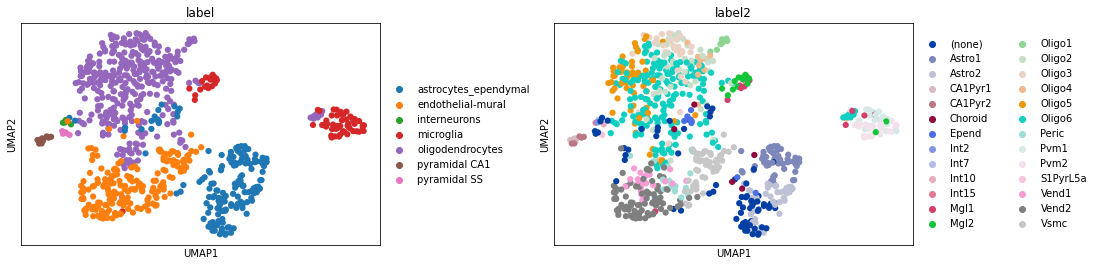

In [9]:
sc.pl.umap(adata, color=['label', 'label2'], wspace=0.35)

In [10]:
adata.obs['size_factors'] = adata.X.sum(1)
adata.obs['size_factors']

52      829.837402
203     649.443848
218     731.535034
271     744.612427
279     780.697571
           ...    
3000    977.886230
3001    765.980347
3002    801.452393
3003    683.318848
3004    850.031311
Name: size_factors, Length: 773, dtype: float32

In [11]:
adata.obs['label'].cat.categories

Index(['astrocytes_ependymal', 'endothelial-mural', 'interneurons',
       'microglia', 'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'],
      dtype='object')

In [12]:
encoder_study = OneHotEncoder(sparse=False, dtype=np.float32)
encoder_study.fit(adata.obs['label'].to_numpy()[:, None])

OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False)

In [13]:
adata.obs['label2'].cat.categories

Index(['(none)', 'Astro1', 'Astro2', 'CA1Pyr1', 'CA1Pyr2', 'Choroid', 'Epend',
       'Int2', 'Int7', 'Int10', 'Int15', 'Mgl1', 'Mgl2', 'Oligo1', 'Oligo2',
       'Oligo3', 'Oligo4', 'Oligo5', 'Oligo6', 'Peric', 'Pvm1', 'Pvm2',
       'S1PyrL5a', 'Vend1', 'Vend2', 'Vsmc'],
      dtype='object')

In [14]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['label2'])

LabelEncoder()

In [15]:
use_cuda = torch.cuda.is_available()

In [16]:
encoders = {
    'obs': {
        'label': lambda s: encoder_study.transform(s.to_numpy()[:, None]),
        'label2': encoder_celltype.transform
    }
}

In [17]:
dataloader = AnnLoader(adata, batch_size=128, shuffle=True, convert=encoders, use_cuda=use_cuda)

In [18]:
dataloader.dataset

AnnCollection object with n_obs × n_vars = 773 × 4576
  constructed from 1 AnnData objects
    view of obsm: 'X_pca', 'X_umap'
    obs: 'cell_ids', 'label', 'label2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors'

In [19]:
data_1=dataloader.dataset[:773]

In [20]:
data_1

AnnCollectionView object with n_obs × n_vars = 773 × 4576
    obsm: 'X_pca', 'X_umap'
    obs: 'cell_ids', 'label', 'label2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'size_factors'

In [21]:
batch = dataloader.dataset[:773]

print('X:', batch.X.device, batch.X.dtype)
print('X_pca:', batch.obsm['X_pca'].device, batch.obsm['X_pca'].dtype)
print('X_umap:', batch.obsm['X_umap'].device, batch.obsm['X_umap'].dtype)
# and here you can see that the converters are applied to 'study' and 'cell_type'.
print('label:', batch.obs['label'].device, batch.obs['label'].dtype)
print('label2:', batch.obs['label2'].device, batch.obs['label2'].dtype)

X: cpu torch.float32
X_pca: cpu torch.float32
X_umap: cpu torch.float32
label: cpu torch.float32
label2: cpu torch.int32


In [22]:
n_conds = len(adata.obs['label'].cat.categories)
n_classes = len(adata.obs['label2'].cat.categories)
cvae = CVAE(adata.n_vars, n_conds=n_conds, n_classes=n_classes, hidden_dims=[256, 256], latent_dim=10)

if use_cuda:
    cvae.cuda()

In [23]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO())

In [24]:
def train(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        epoch_loss += svi.step( batch.X, batch.obs['label'], batch.obs['label2'],  batch.obs['size_factors'])

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

Because of my computer performance and computing power, I only trained 200 times. In fact, I trained 1000 times at most, but the effect is still not good. It should be the problem of parameter setting.

In [25]:
NUM_EPOCHS = 200
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 20 == 0 or epoch == NUM_EPOCHS-1:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 1394.4924
[epoch 020]  average training loss: 1064.7062
[epoch 040]  average training loss: 1008.0688
[epoch 060]  average training loss: 960.8044
[epoch 080]  average training loss: 918.7416
[epoch 100]  average training loss: 882.0911
[epoch 120]  average training loss: 850.0547
[epoch 140]  average training loss: 820.5187
[epoch 160]  average training loss: 794.1059
[epoch 180]  average training loss: 769.9773
[epoch 199]  average training loss: 750.2477


In [26]:
full_data = dataloader.dataset[:] # No copies yet, nothing is copied until you access specific attributes (.X, .obsm etc.).

In [27]:
means = cvae.encoder(full_data.X, full_data.obs['label'])[:, :10] # get mean values of the latent variables

In [28]:
adata.obsm['X_cvae'] = means.data.cpu().numpy()

In [29]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

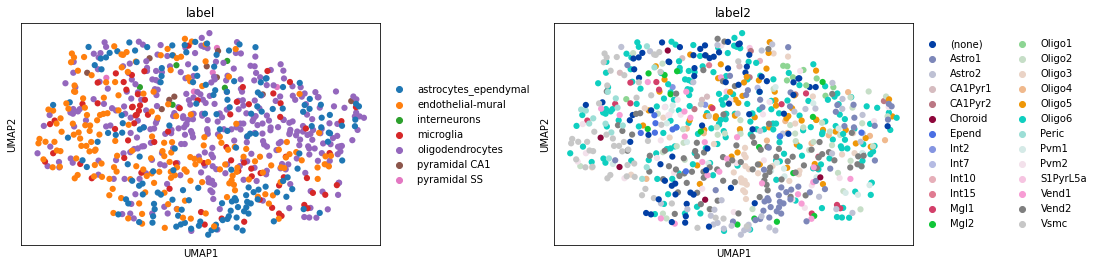

In [30]:
sc.pl.umap(adata, color=['label', 'label2'], wspace=0.35)

In [31]:
accuracy = (cvae.classifier(means).argmax(dim=-1)==full_data.obs['label2']).sum().item()/adata.n_obs

In [32]:
accuracy

0.46959896507115134